In [1]:
%matplotlib inline

import os
from importlib import reload
from collections import Counter

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder, StandardScaler
import keras
from keras.layers import Activation, Dense, Conv1D, Conv2D, MaxPooling1D, Flatten, Reshape

import librosa
import librosa.display

import utils
reload(utils)

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (17, 5)

Using TensorFlow backend.


In [2]:
# Load metadata and features.
tracks = utils.load('fma_metadata/tracks.csv')
genres = utils.load('fma_metadata/genres.csv')
features = utils.load('fma_metadata/features.csv')
echonest = utils.load('fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

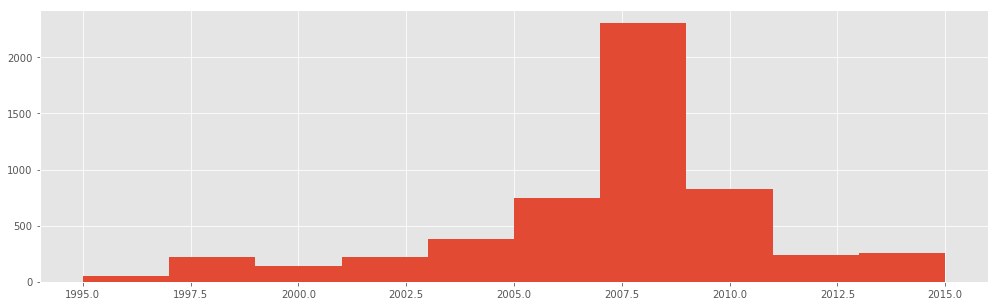

In [3]:
tracks['track']['date_recorded'].map(lambda x: x.year).hist(range=(1995, 2015))

In [4]:
tracks['track']['genre_top'].isnull().sum()

56976

In [5]:
ipd.display(tracks['track'].head())
ipd.display(tracks['album'].head())
ipd.display(tracks['artist'].head())
ipd.display(tracks['set'].head())

,bit_rate,comments,composer,date_created,date_recorded,duration,favorites,genre_top,genres,genres_all,information,interest,language_code,license,listens,lyricist,number,publisher,tags,title
track_id,,,,,,,,,,,,,,,,,,,,
2,256000,0,NaN,2008-11-26 01:48:12,2008-11-26,168,2,Hip-Hop,[21],[21],NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
3,256000,0,NaN,2008-11-26 01:48:14,2008-11-26,237,1,Hip-Hop,[21],[21],NaN,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave
5,256000,0,NaN,2008-11-26 01:48:20,2008-11-26,206,6,Hip-Hop,[21],[21],NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
10,192000,0,Kurt Vile,2008-11-25 17:49:06,2008-11-26,161,178,Pop,[10],[10],NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
20,256000,0,NaN,2008-11-26 01:48:56,2008-01-01,311,0,NaN,"[76, 103]","[17, 10, 76, 103]",NaN,978,en,Attribution-NonCommercial-NoDerivatives (aka M...,361,NaN,3,NaN,[],Spiritual Level


,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,tags,title,tracks,type
track_id,,,,,,,,,,,,,
2,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
3,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
5,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],AWOL - A Way Of Life,7,Album
10,0,2008-11-26 01:45:08,2008-02-06,NaN,4,6,NaN,47632,NaN,[],Constant Hitmaker,2,Album
20,0,2008-11-26 01:45:05,2009-01-06,NaN,2,4,"<p> ""spiritual songs"" from Nicky Cook</p>",2710,NaN,[],Niris,13,Album


,active_year_begin,active_year_end,associated_labels,bio,comments,date_created,favorites,id,latitude,location,longitude,members,name,related_projects,tags,website,wikipedia_page
track_id,,,,,,,,,,,,,,,,,
2,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
3,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
5,2006-01-01,NaT,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0,2008-11-26 01:42:32,9,1,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,[awol],http://www.AzillionRecords.blogspot.com,NaN
10,NaT,NaT,"Mexican Summer, Richie Records, Woodsist, Skul...","<p><span style=""font-family:Verdana, Geneva, A...",3,2008-11-26 01:42:55,74,6,NaN,NaN,NaN,"Kurt Vile, the Violators",Kurt Vile,NaN,"[philly, kurt vile]",http://kurtvile.com,NaN
20,1990-01-01,2011-01-01,NaN,<p>Songs written by: Nicky Cook</p>\n<p>VOCALS...,2,2008-11-26 01:42:52,10,4,51.895927,Colchester England,0.891874,Nicky Cook\n,Nicky Cook,NaN,"[instrumentals, experimental pop, post punk, e...",NaN,NaN


,split,subset
track_id,,
2,training,small
3,training,medium
5,training,small
10,training,small
20,training,large


In [6]:
print('total rows with non-empty tags', 
      tracks['track']['tags'].map(lambda x: len(x) > 0).sum())

tags = Counter()
for row in tracks['album']['tags']:
    for tag in row:
        tags[tag] += 1 
        
tags.most_common(10)

total rows with non-empty tags 23496


[('experimental', 3233),
 ('electronic', 2380),
 ('noise', 1613),
 ('instrumental', 1508),
 ('idm', 1410),
 ('ambient', 1363),
 ('improvisation', 1130),
 ('all styles experimental', 1106),
 ('glitch', 1065),
 ('folk', 998)]

In [7]:
print('{} top-level genres'.format(len(genres['top_level'].unique())))
genres.loc[genres['top_level'].unique()].sort_values('#tracks', ascending=False)

16 top-level genres


,#tracks,parent,title,top_level
genre_id,,,,
38,38154,0,Experimental,38
15,34413,0,Electronic,15
12,32923,0,Rock,12
1235,14938,0,Instrumental,1235
10,13845,0,Pop,10
17,12706,0,Folk,17
21,8389,0,Hip-Hop,21
2,5271,0,International,2
4,4126,0,Jazz,4


((2000, 2), (2000,))

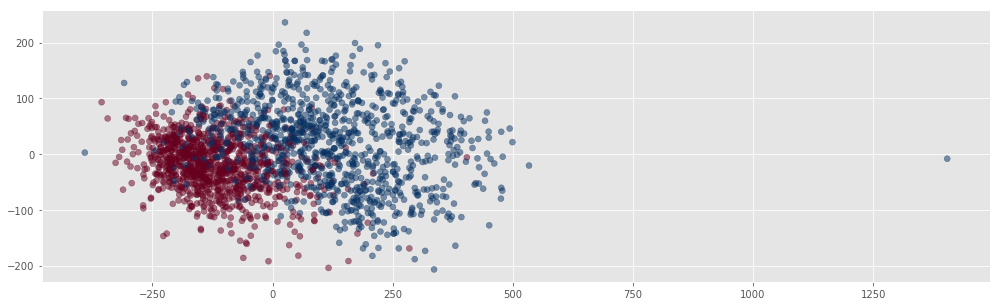

In [8]:
small = tracks['set', 'subset'] <= 'small'
def select(genre):
    return tracks['track', 'genre_top'].map(lambda genres: genre == genres)
genre1 = select('Instrumental') # Instrumental.
genre2 = select('Hip-Hop') # Hip-Hop.

X = features.loc[small & (genre1 | genre2)]['mfcc']
X = skl.decomposition.PCA(n_components=2).fit_transform(X)

y = tracks.loc[small & (genre1 | genre2)][('track', 'genre_top')]
y = skl.preprocessing.LabelEncoder().fit_transform(y)

plt.scatter(X[:,0], X[:,1], c=y, cmap='RdBu', alpha=0.5)
X.shape, y.shape

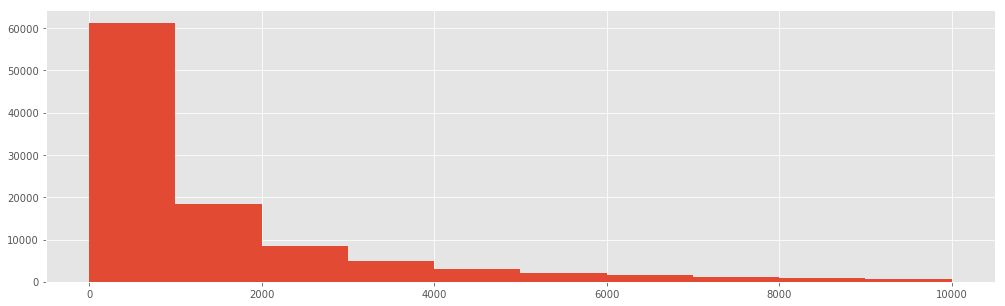

In [9]:
tracks['track']['listens'].hist(range=(0, 10000))

In [10]:
subset = tracks.index[tracks['set', 'subset'] <= 'small']

assert subset.isin(tracks.index).all()
assert subset.isin(features.index).all()

features_all = features.join(echonest, how='inner').sort_index(axis=1)
print('Not enough Echonest features: {}'.format(features_all.shape))

tracks = tracks.loc[subset]
features_all = features.loc[subset]

tracks.shape, features_all.shape

Not enough Echonest features: (13129, 767)


((8000, 52), (8000, 518))

In [11]:
train = tracks.index[tracks['set', 'split'] == 'training']
val = tracks.index[tracks['set', 'split'] == 'validation']
test = tracks.index[tracks['set', 'split'] == 'test']

print('{} training examples, {} validation examples, {} testing examples'.format(*map(len, [train, val, test])))

genres = list(MultiLabelBinarizer().fit(tracks['track', 'genre_top']).classes_)
#genres = list(tracks['track', 'genre_top'].unique())
print('Top genres ({}): {}'.format(len(genres), genres))
genres = list(MultiLabelBinarizer().fit(tracks['track', 'genres_all']).classes_)
print('All genres ({}): {}'.format(len(genres), genres))

6400 training examples, 800 validation examples, 800 testing examples
Top genres (22): ['-', 'E', 'F', 'H', 'I', 'P', 'R', 'a', 'c', 'e', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'x']
All genres (114): [1, 2, 6, 10, 12, 15, 16, 17, 18, 21, 22, 25, 26, 27, 30, 31, 32, 33, 36, 38, 41, 42, 45, 46, 47, 49, 53, 58, 64, 66, 70, 71, 76, 77, 79, 81, 83, 85, 86, 88, 89, 90, 92, 94, 98, 100, 101, 102, 103, 107, 109, 111, 113, 117, 118, 125, 130, 167, 171, 172, 174, 177, 180, 181, 182, 183, 184, 185, 186, 214, 224, 232, 236, 240, 247, 250, 267, 286, 296, 297, 314, 337, 359, 360, 361, 362, 400, 401, 404, 439, 440, 456, 468, 491, 495, 502, 504, 514, 524, 538, 539, 542, 580, 602, 619, 695, 741, 763, 808, 811, 1032, 1060, 1193, 1235]


In [12]:
AUDIO_PATH = 'fma_small/'
class MfccLoader(utils.Loader):
    raw_loader = utils.FfmpegLoader(sampling_rate=22050)
    #shape = (13, 190)  # For segmented tracks.
    shape = (13, 2582)
    def load(self, filename):
        import librosa
        x = self.raw_loader.load(filename)
        # Each MFCC frame spans 23ms on the audio signal with 50% overlap with the adjacent frames.
        mfcc = librosa.feature.mfcc(x, sr=22050, n_mfcc=13, n_fft=512, hop_length=256)
        return mfcc

labels_onehot = MultiLabelBinarizer().fit_transform(tracks['track', 'genre_top'])
labels_onehot = pd.DataFrame(labels_onehot, index=tracks.index)
loader = MfccLoader()
SampleLoader = utils.build_sample_loader(AUDIO_PATH , labels_onehot, loader)
loader.load(utils.get_audio_path(AUDIO_PATH, 2))[0].shape

(2582,)

In [13]:
reload(utils)

<module 'utils' from '/Users/Yiyi/Documents/School/FMA/utils.py'>

In [14]:
# Keras parameters.
# NB_WORKER = len(os.sched_getaffinity(0))  # number of usables CPUs
params = {'pickle_safe': False}

In [15]:
keras.backend.clear_session()

model = keras.models.Sequential()
model.add(Reshape((*loader.shape, 1),  input_shape=loader.shape))
print('1st layer output shape:', model.output_shape)

model.add(Conv2D(3, (13, 10), strides = (1, 4)))
model.add(Activation("relu"))
print('2nd layer output shape:', model.output_shape)

model.add(Conv2D(15, (1, 10), strides = (1, 4)))
model.add(Activation("relu"))
print('3rd layer output shape:', model.output_shape)

model.add(Conv2D(65, (1, 10), strides = (1, 4)))
model.add(Activation("relu"))
print('4th layer output shape:', model.output_shape)

model.add(Flatten())
print(model.output_shape)
model.add(Dense(labels_onehot.shape[1]))
model.add(Activation("softmax"))
print(model.output_shape)

optimizer = keras.optimizers.SGD(1e-3) # lr=0.01, momentum=0.9, nesterov=True)
# optimizer = keras.optimizers.Adam() # lr=1e-5)#
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.fit_generator(SampleLoader(train, batch_size=16), train.size, epochs=1, **params)
# loss = model.evaluate_generator(SampleLoader(val, batch_size=16), val.size, **params)
# loss = model.evaluate_generator(SampleLoader(test, batch_size=16), test.size, **params)
loss = model.evaluate_generator(SampleLoader(val, batch_size=16), val.size, **params)
# Y = model.predict_generator(loader, test.size, pickle_safe=True, nb_worker=NB_WORKER, max_q_size=5)

loss

1st layer output shape: (None, 13, 2582, 1)
2nd layer output shape: (None, 1, 644, 3)
3rd layer output shape: (None, 1, 159, 15)
4th layer output shape: (None, 1, 38, 65)
(None, 2470)
(None, 22)
Epoch 1/1
 773/6400 [==>...........................] - ETA: 16457s - loss: 20.4227 - acc: 2.4256e-0454578


KeyboardInterrupt: 